In [1]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner
from astropy.stats import LombScargle


In [2]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e19-LLRR.dat')
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

In [7]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.6 < b < 2.2:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [5]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [6]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.029667824877650056 1.9440762705301373


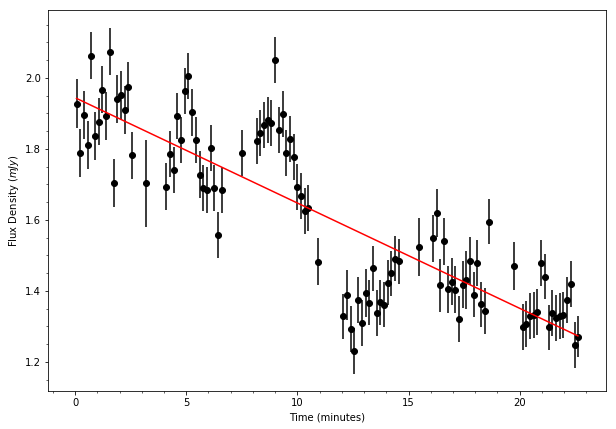

In [7]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel.png')
plt.show()

In [8]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)
linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.02845268,  1.93064835],
        [-0.03034129,  1.94888879],
        [-0.02962924,  1.95103145],
        [-0.0298148 ,  1.95707614],
        [-0.03061383,  1.95585876],
        [-0.02892718,  1.93768377],
        [-0.0298874 ,  1.9499322 ],
        [-0.03003143,  1.93851276],
        [-0.02913538,  1.94017591],
        [-0.02881251,  1.93002354],
        [-0.02812413,  1.93562051],
        [-0.0292791 ,  1.94949017],
        [-0.02909168,  1.93889014],
        [-0.02978338,  1.94594816],
        [-0.02974967,  1.93221551],
        [-0.02966831,  1.94876212],
        [-0.03007248,  1.94744466],
        [-0.03002579,  1.95569037],
        [-0.02834864,  1.92796761],
        [-0.03045697,  1.95760412],
        [-0.03066901,  1.94186142],
        [-0.02770066,  1.9197611 ],
        [-0.02814606,  1.91911376],
        [-0.02843943,  1.94209176],
        [-0.03078317,  1.96125007],
        [-0.03046498,  1.94320953],
        [-0.02933837,  1.93452661],
        [-0.0296432 ,  1.941

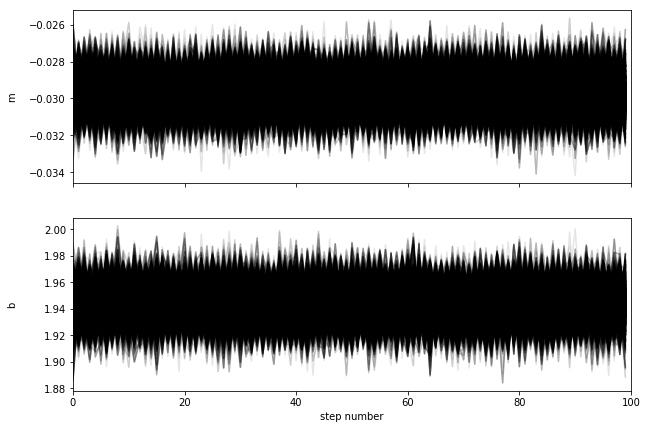

In [9]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_linearTrace.png')
plt.show()

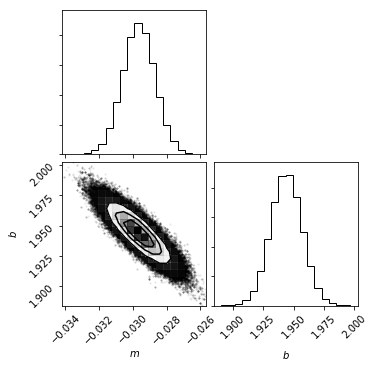

In [10]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e19_linearCorner.png')
plt.show()

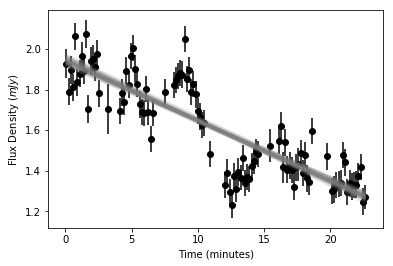

In [11]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_data.png')
plt.show()

In [12]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

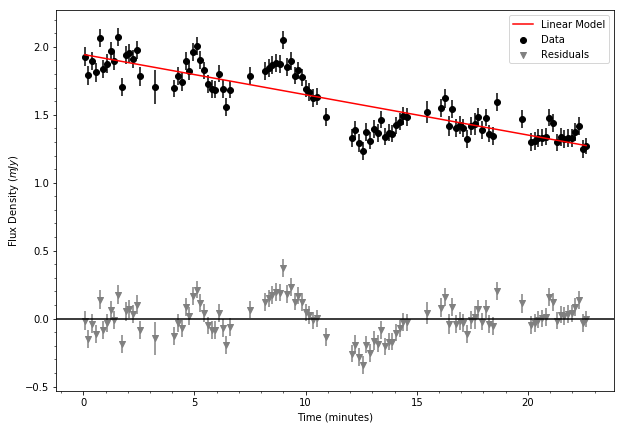

In [13]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,7))
plt.scatter(x,y,color='k',marker='o',label='Data')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='_nolegend_')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.scatter(x,linear_resid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel_fit.png')
plt.show()

In [14]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(x)-2)

3.8256599485724623

## Fitting an logistic function


In [49]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -2.5 < l < 0 and -5 < k < 10 and 9 < x0 < 15 and 1.6 < y0 < 2.0:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [16]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

-0.4528223066730901 3.1683989202336402 10.39846579331271 1.8441010944872955


In [17]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[-0.44166015,  2.71676866, 10.55281948,  1.8324375 ],
        [-0.43957337,  3.81034999, 10.44463338,  1.8320669 ],
        [-0.4712715 ,  2.83584953, 10.26945442,  1.85982712],
        [-0.44154159,  3.80985974, 10.25271766,  1.83698055],
        [-0.45029459,  3.91900643, 10.29053323,  1.84362781],
        [-0.46203049,  3.10124968, 10.3375076 ,  1.84988053],
        [-0.42451436,  3.33020867, 10.33501051,  1.8378336 ],
        [-0.43412539,  4.09485079, 10.32567359,  1.84121676],
        [-0.4434258 ,  2.71959859, 10.4018177 ,  1.85526202],
        [-0.45229661,  2.20266567, 10.6411494 ,  1.83858265],
        [-0.450511  ,  3.27762664, 10.40769436,  1.84555403],
        [-0.47698586,  3.43992736, 10.65193979,  1.85348985],
        [-0.47026098,  2.767101  , 10.37108058,  1.85684889],
        [-0.44175108,  3.28847226, 10.44812259,  1.83466752],
        [-0.44988838,  2.77601537, 10.35613819,  1.85298294],
        [-0.43102167,  3.23021257, 10.29861492,  1.83907539],
        

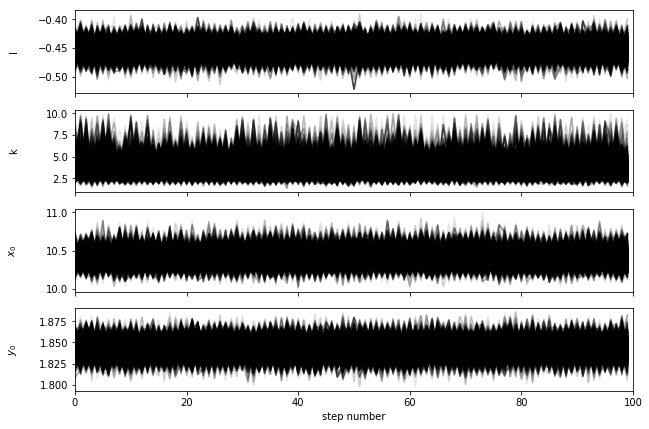

In [18]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_Trace.png')
plt.show()

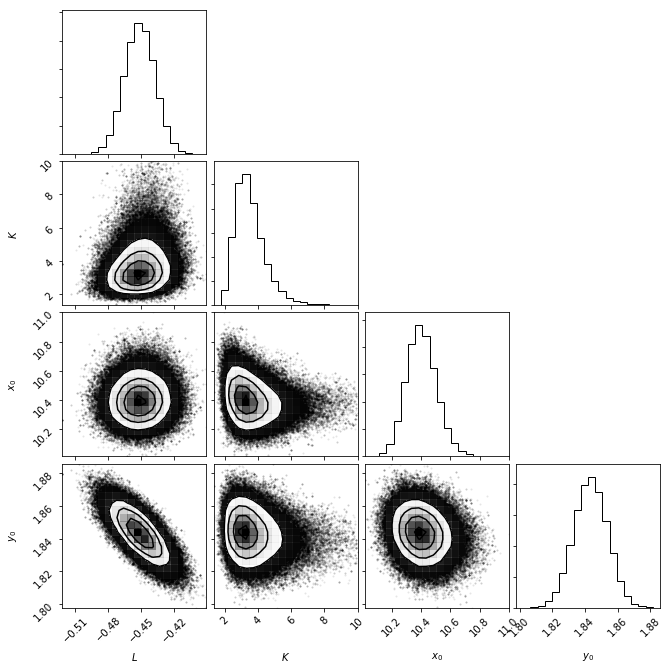

In [19]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/1314e15_logCorner.png')
plt.show()

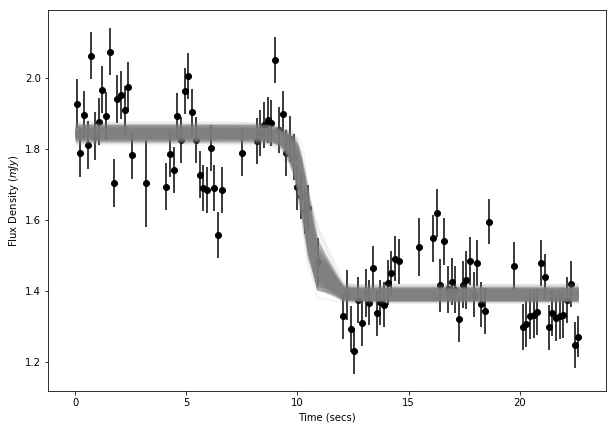

In [20]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_log.png')
plt.show()

In [21]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [50]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel([-0.45178,3.38073,10.39821,1.84334],x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(12,9))
binPlot(Type='minutes')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/1314e19_logModel.png')
plt.show()

NameError: name 'logFlat' is not defined

In [23]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(x)-4)

2.219513279241167

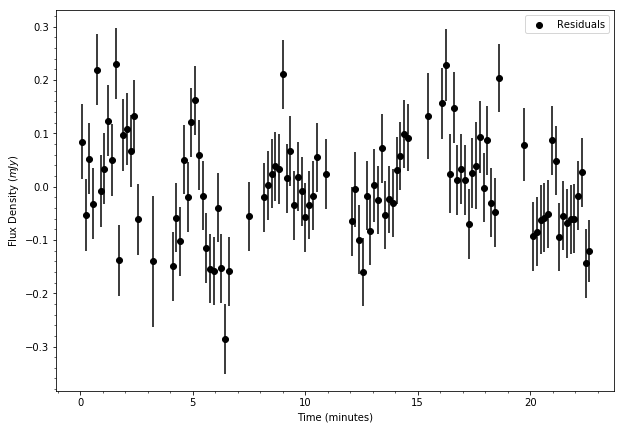

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(x,logResid,color='black',marker='o',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='black',label='_nolegend_',linestyle='None')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.show()

## e19 Looking at Stokes I, V and circular polarization

In [4]:
rr = pd.read_table('1314/2M1314e19-RR.dat')
ll = pd.read_table('1314/2M1314e19-LL.dat')

rr = binning(rr,10,2)
ll = binning(ll,10,2)

In [5]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

In [6]:
data = pd.DataFrame(data={'time':time,'stI':stI,'stErr':stErr})
data.to_csv('stokesI.csv')

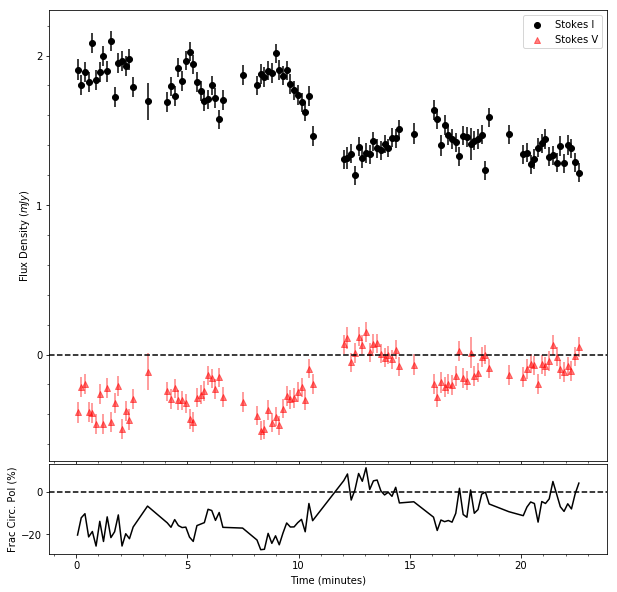

In [7]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':0.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='--')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.savefig('plots/1314e19_stokes.png')
plt.show()

In [8]:
modelSub = stI - log_model

plt.figure(figsize=(10,7))
plt.scatter(time,modelSub,color='k',marker='o',label='Model Subtracted')
plt.errorbar(time,modelSub,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.ylim(-0.5,0.8)
plt.legend(loc='best')
plt.show()

NameError: name 'log_model' is not defined

In [9]:
freq, power = LombScargle(time,modelSub,stErr,nterms=2).autopower()
plt.figure(figsize=(10,7))
plt.plot(freq,power)
plt.show()

lomb = pd.DataFrame(data={'freq':freq,'power':power,'time':1/freq*60})
lomb = lomb.sort_values('power',ascending=False)
print(lomb)

best_freq = lomb['freq'].iloc[1]
x_fit = np.linspace(np.min(time),np.max(time))
y_fit = LombScargle(time,modelSub,stErr,nterms=2).model(x_fit,best_freq)

plt.figure(figsize=(10,7))
plt.scatter(time,modelSub,color='black')
plt.errorbar(time,modelSub,color='black',yerr=stErr,linestyle='None')
plt.plot(x_fit,y_fit,color='red')
plt.ylim(-0.5,0.8)
plt.show()
print(1/best_freq)

NameError: name 'modelSub' is not defined

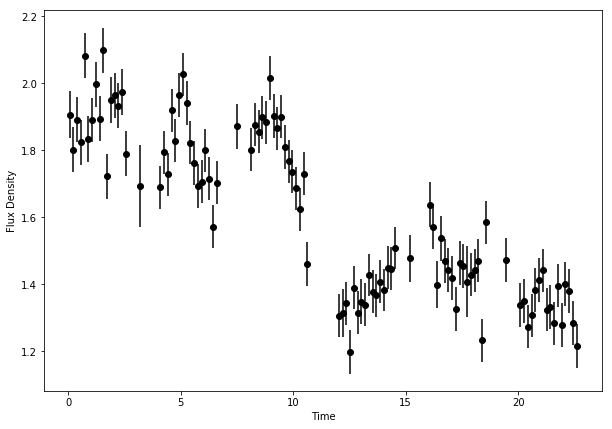

In [10]:
# Using gaussian process to reduce the data

plt.figure(figsize=(10,7))
plt.scatter(time,stI,color='k',marker='o')
plt.errorbar(time,stI,color='k',yerr=stErr,linestyle='none')
plt.xlabel('Time')
plt.ylabel('Flux Density')
plt.show()



In [10]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

time = time[:,np.newaxis]
stI = stI[:,None]
stErr = stErr[:,None]

In [30]:
low = pd.read_table('1314/2M1314e19-5GHz.dat')
high = pd.read_table('1314/2M1314e19-7GHz.dat')

low = binning(low,10,2)
high = binning(high,10,2)

low = low[low['nsamp']>4500]
high = high[high['nsamp']>4500]

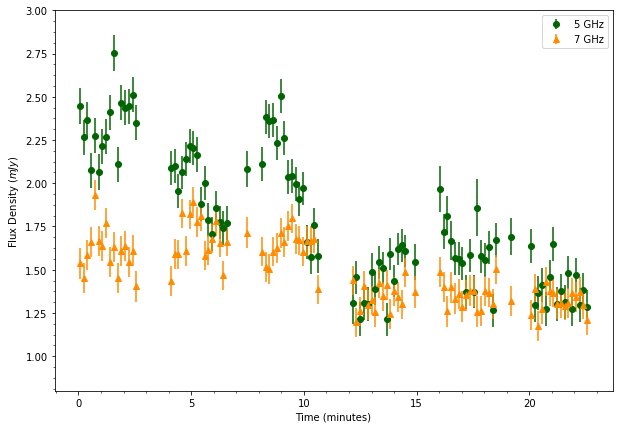

In [33]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',color='darkgreen',linestyle='None',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='^',color='darkorange',linestyle='None',label='7 GHz')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.ylim(0.8,3)
plt.minorticks_on()
plt.show()

In [37]:
low['re'].mean()

1.802068751273253